In [31]:
import hydrofunctions as hf, pandas as pd

site = "03443000"

# Get the data
nwis_data = hf.NWIS(site, 'dv', "1970-01-01", "2025-06-01", parameterCd='00065')
df = nwis_data.df()

# Inspect the DataFrame structure
print("DataFrame shape:", df.shape)
print("Column names:", df.columns.tolist())
print("Column levels:", df.columns.nlevels)
print("First few rows:")
print(df.head())

# Extract the mean-stage series (statistic code 00003) directly by column name
stage_col = f'USGS:{site}:00065:00003'
stage = df[stage_col].rename('stage_ft')

print("\nExtracted stage series:")
print(stage.head())
print(f"Stage series shape: {stage.shape}")
print(f"Number of null values: {stage.isnull().sum()}")



Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=03443000&parameterCd=00065&startDT=1970-01-01&endDT=2025-06-01
DataFrame shape: (10837, 6)
Column names: ['USGS:03443000:00065:00001', 'USGS:03443000:00065:00001_qualifiers', 'USGS:03443000:00065:00002', 'USGS:03443000:00065:00002_qualifiers', 'USGS:03443000:00065:00003', 'USGS:03443000:00065:00003_qualifiers']
Column levels: 1
First few rows:
                           USGS:03443000:00065:00001  \
datetimeUTC                                            
1995-10-01 00:00:00+00:00                       6.48   
1995-10-02 00:00:00+00:00                       6.43   
1995-10-03 00:00:00+00:00                       6.78   
1995-10-04 00:00:00+00:00                      16.22   
1995-10-05 00:00:00+00:00                      19.04   

                          USGS:03443000:00065:00001_qualifiers  \
datetimeUTC                                                      
1995-10-01 00:00:00+00:00                    

In [32]:
print(f"Original stage series length: {len(stage)}")
print(f"Number of null values before cleaning: {stage.isnull().sum()}")

# --- ROBUST GAP HANDLING ---
is_nan = stage.isnull()
# Create groups of consecutive values
gap_groups = is_nan.groupby((~is_nan).cumsum())
# Find the indices of any group that has a length > 3
long_gap_indices = gap_groups.filter(lambda g: g.sum() > 3).index

if not long_gap_indices.empty:
    print(f"Removing {len(long_gap_indices)} rows due to gaps > 3 days.")
    # Drop all rows that are part of a long gap
    stage_clean = stage.drop(index=long_gap_indices)
else:
    print("No gaps longer than 3 days found.")
    stage_clean = stage.copy()

# Interpolate the remaining short gaps (<= 3 days)
stage_clean.interpolate(method='linear', inplace=True)
# --- END OF ROBUST GAP HANDLING ---

print(f"Number of null values after cleaning: {stage_clean.isnull().sum()}")



Original stage series length: 10837
Number of null values before cleaning: 49
Removing 22 rows due to gaps > 3 days.
Number of null values after cleaning: 0


In [33]:
# Convert to a final DataFrame and save
# Note: hydrofunctions uses 'datetimeUTC', let's handle that
final_df = stage_clean.to_frame()
final_df.index.name = 'datetime'
final_df = final_df.reset_index()

# Convert feet to meters
final_df['stage_m'] = (final_df['stage_ft'] * 0.3048).round(2)

# Keep only the essential columns
final_df = final_df[['datetime', 'stage_m']]

# Save the final dataframe to a csv file
final_df.to_csv("dataset.csv", index=False)

print("\nDataFrame saved to dataset.csv")
print(f"Final dataset shape: {final_df.shape}")
print(final_df.head())
print("\nDataset info:")
print(f"Date range: {final_df['datetime'].min()} to {final_df['datetime'].max()}")
print(f"Stage range: {final_df['stage_m'].min():.2f}m to {final_df['stage_m'].max():.2f}m")





DataFrame saved to dataset.csv
Final dataset shape: (10815, 2)
                   datetime  stage_m
0 1995-10-01 00:00:00+00:00     1.96
1 1995-10-02 00:00:00+00:00     1.93
2 1995-10-03 00:00:00+00:00     1.91
3 1995-10-04 00:00:00+00:00     3.79
4 1995-10-05 00:00:00+00:00     5.41

Dataset info:
Date range: 1995-10-01 00:00:00+00:00 to 2025-06-01 00:00:00+00:00
Stage range: 1.06m to 6.59m


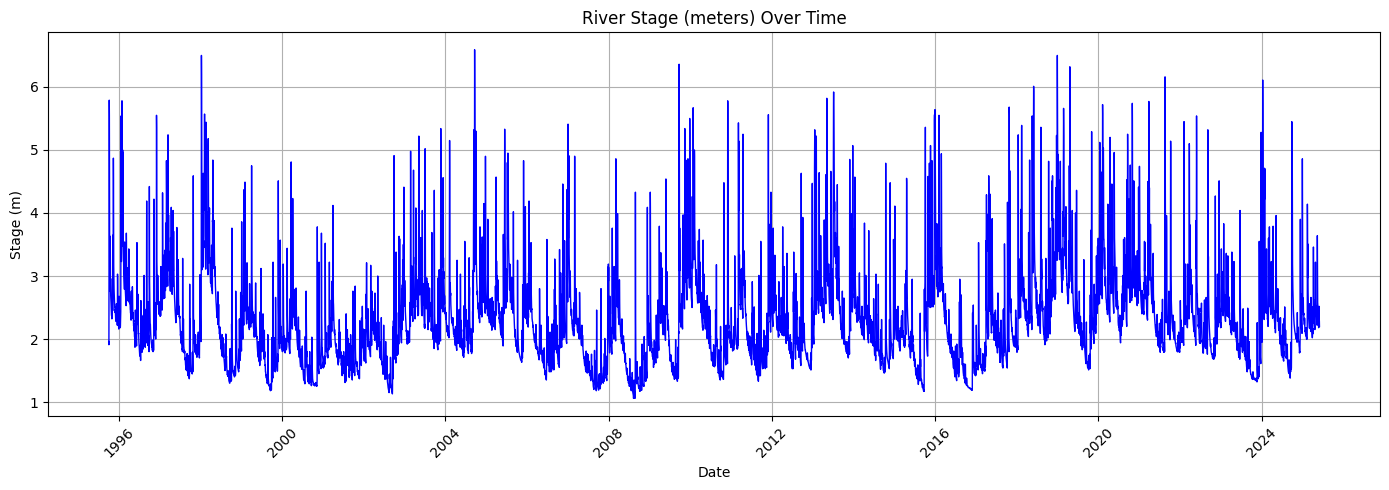

In [35]:
import matplotlib.pyplot as plt

# Visualize the dataset for stage_m
plt.figure(figsize=(14, 5))
plt.plot(final_df['datetime'], final_df['stage_m'], color='b', linewidth=1)
plt.title('River Stage (meters) Over Time')
plt.xlabel('Date')
plt.ylabel('Stage (m)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [36]:
import hydrofunctions as hf, pandas as pd

site = "03443000"

# Get both stage and discharge data
nwis_data = hf.NWIS(site, 'dv', "1970-01-01", "2025-06-01", parameterCd=['00065', '00060'])
df = nwis_data.df()

# Inspect the DataFrame structure
print("DataFrame shape:", df.shape)
print("Column names:", df.columns.tolist())
print("Column levels:", df.columns.nlevels)
print("First few rows:")
print(df.head())

# Extract both stage and discharge series (statistic code 00003 = daily mean)
stage_col = f'USGS:{site}:00065:00003'
discharge_col = f'USGS:{site}:00060:00003'

stage = df[stage_col].rename('stage_ft')
discharge = df[discharge_col].rename('discharge_cfs')

print("\nExtracted series:")
print("Stage series:")
print(stage.head())
print(f"Stage series shape: {stage.shape}")
print(f"Number of null values in stage: {stage.isnull().sum()}")

print("\nDischarge series:")
print(discharge.head())
print(f"Discharge series shape: {discharge.shape}")
print(f"Number of null values in discharge: {discharge.isnull().sum()}")

# Combine both series into a single DataFrame
combined_data = pd.DataFrame({
    'stage_ft': stage,
    'discharge_cfs': discharge
})

print(f"\nOriginal combined data length: {len(combined_data)}")
print(f"Number of null values before cleaning:")
print(combined_data.isnull().sum())

# --- ROBUST GAP HANDLING ---
# Check for gaps in either stage or discharge data
# A row is considered missing if either parameter is null
is_missing = combined_data.isnull().any(axis=1)

# Create groups of consecutive missing values
gap_groups = is_missing.groupby((~is_missing).cumsum())
# Find the indices of any group that has a length > 3
long_gap_indices = gap_groups.filter(lambda g: g.sum() > 3).index

if not long_gap_indices.empty:
    print(f"Removing {len(long_gap_indices)} rows due to gaps > 3 days.")
    # Drop all rows that are part of a long gap
    combined_clean = combined_data.drop(index=long_gap_indices)
else:
    print("No gaps longer than 3 days found.")
    combined_clean = combined_data.copy()

# Interpolate the remaining short gaps (<= 3 days)
combined_clean.interpolate(method='linear', inplace=True)
# --- END OF ROBUST GAP HANDLING ---

print(f"Number of null values after cleaning:")
print(combined_clean.isnull().sum())

# Convert to a final DataFrame and save
# Note: hydrofunctions uses 'datetimeUTC', let's handle that
final_df = combined_clean.reset_index()
final_df.index.name = None

# Convert feet to meters for stage, and cubic feet per second to cubic meters per second for discharge
final_df['stage_m'] = (final_df['stage_ft'] * 0.3048).round(3)
final_df['discharge_cms'] = (final_df['discharge_cfs'] * 0.0283168).round(3)

# Keep only the essential columns
final_df = final_df[['datetimeUTC', 'stage_m', 'discharge_cms']].rename(columns={'datetimeUTC': 'datetime'})

# Save the final dataframe to a csv file
final_df.to_csv("dataset.csv", index=False)

print("\nDataFrame saved to dataset.csv")
print(f"Final dataset shape: {final_df.shape}")
print(final_df.head())
print("\nDataset info:")
print(f"Date range: {final_df['datetime'].min()} to {final_df['datetime'].max()}")
print(f"Stage range: {final_df['stage_m'].min():.3f}m to {final_df['stage_m'].max():.3f}m")
print(f"Discharge range: {final_df['discharge_cms'].min():.3f}m³/s to {final_df['discharge_cms'].max():.3f}m³/s")



Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=03443000&parameterCd=00065%2C00060&startDT=1970-01-01&endDT=2025-06-01
DataFrame shape: (20241, 12)
Column names: ['USGS:03443000:00060:00001', 'USGS:03443000:00060:00001_qualifiers', 'USGS:03443000:00060:00002', 'USGS:03443000:00060:00002_qualifiers', 'USGS:03443000:00060:00003', 'USGS:03443000:00060:00003_qualifiers', 'USGS:03443000:00065:00001', 'USGS:03443000:00065:00001_qualifiers', 'USGS:03443000:00065:00002', 'USGS:03443000:00065:00002_qualifiers', 'USGS:03443000:00065:00003', 'USGS:03443000:00065:00003_qualifiers']
Column levels: 1
First few rows:
                           USGS:03443000:00060:00001  \
datetimeUTC                                            
1970-01-01 00:00:00+00:00                        NaN   
1970-01-02 00:00:00+00:00                        NaN   
1970-01-03 00:00:00+00:00                        NaN   
1970-01-04 00:00:00+00:00                        NaN   
1970-01-05 00:00:0

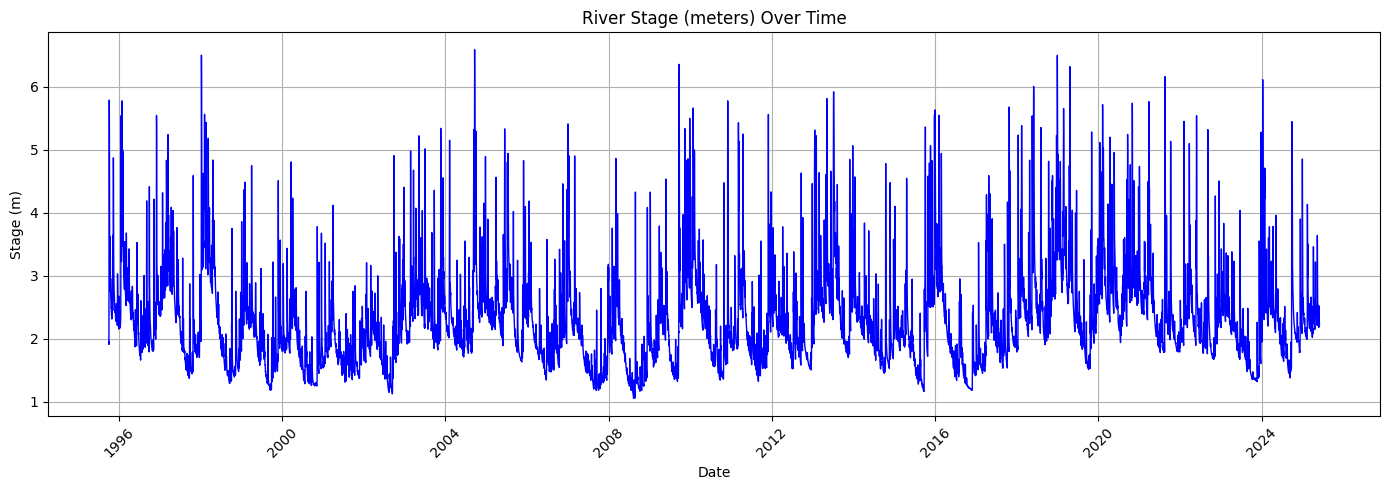

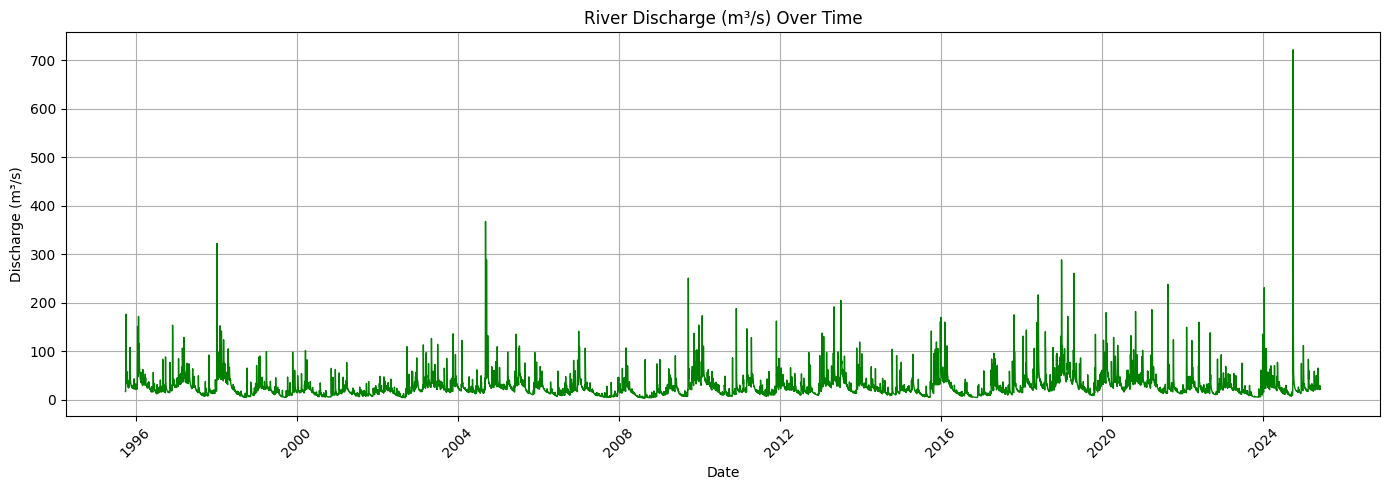

In [39]:
import matplotlib.pyplot as plt

# Visualize the dataset for stage_m
plt.figure(figsize=(14, 5))
plt.plot(final_df['datetime'], final_df['stage_m'], color='b', linewidth=1)
plt.title('River Stage (meters) Over Time')
plt.xlabel('Date')
plt.ylabel('Stage (m)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


# Visualize the dataset for discharge_cms
plt.figure(figsize=(14, 5))
plt.plot(final_df['datetime'], final_df['discharge_cms'], color='g', linewidth=1)
plt.title('River Discharge (m³/s) Over Time')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
